In [65]:
from __future__ import division
import matplotlib.pyplot as plt
import random as rnd
import math
from sklearn.datasets import load_breast_cancer
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [66]:
# Helper function for calculating confusion matrix
def get_confusion_matrix(test_data, target_data, tree_model=None, predictions=None):
    tp, tn, fp, fn = 0, 0, 0, 0
    
    for i in range(len(test_data)):
        if predictions is not None:
            pred = predictions[i]
        else:
            pred = tree_model.predict(test_data[i].reshape(1,-1))[0]
            
        if pred == 1 and target_data[i] == 1:
            tp += 1
        elif pred == 1 and target_data[i] == 0:
            fp += 1
        elif pred == 0 and target_data[i] == 1:
            fn += 1
        else:  # pred == 0 and target_data[i] == 0
            tn += 1
            
    return [[tp, fp], [fn, tn]]

# Helper function for statistics
def get_stats(data, mode=1):
    mean = sum(data) / len(data)
    std = math.sqrt(sum((x - mean) ** 2 for x in data) / (len(data) - 1))
    return mean if mode == 1 else std

## Loading Data

Loading full dataset

In [67]:
bc = load_breast_cancer()
X = bc.data
y = bc.target

Splitting data into train and test

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Decision Tree Classifier

In [69]:
bc_tree = tree.DecisionTreeClassifier(criterion="entropy").fit(X_train, y_train)

## Accuracy

In [70]:
score: float = bc_tree.score(X_test, y_test)
print(f"Initial accuracy score: {score:.4f}")

Initial accuracy score: 0.9123


## Cross Validation

10 fold cross validation

### Custom Cross Validation

In [71]:
scores: list[float] = []
all_trees = []
all_X_test = []
all_y_test = []

for _ in range(10):
    X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=test_size, random_state=11)
    tree_cv = tree.DecisionTreeClassifier(criterion="entropy").fit(X_train_cv, y_train_cv)
    
    all_trees.append(tree_cv)
    all_X_test.append(X_test_cv)
    all_y_test.append(y_test_cv)
    scores.append(tree_cv.score(X_test_cv, y_test_cv))

print(f"Average score: {get_stats(scores):.4f}")
print(f"Standard deviation: {get_stats(scores, 2):.4f}")

Average score: 0.9491
Standard deviation: 0.0129


### Built-In Cross Validation

In [72]:
scores = cross_val_score(bc_tree, X, y, cv=10)
print(f"\nCross-validation results:")
print(f"Average score: {get_stats(scores):.4f}")
print(f"Standard deviation: {get_stats(scores, 2):.4f}")


Cross-validation results:
Average score: 0.9368
Standard deviation: 0.0322


## ROC Curve

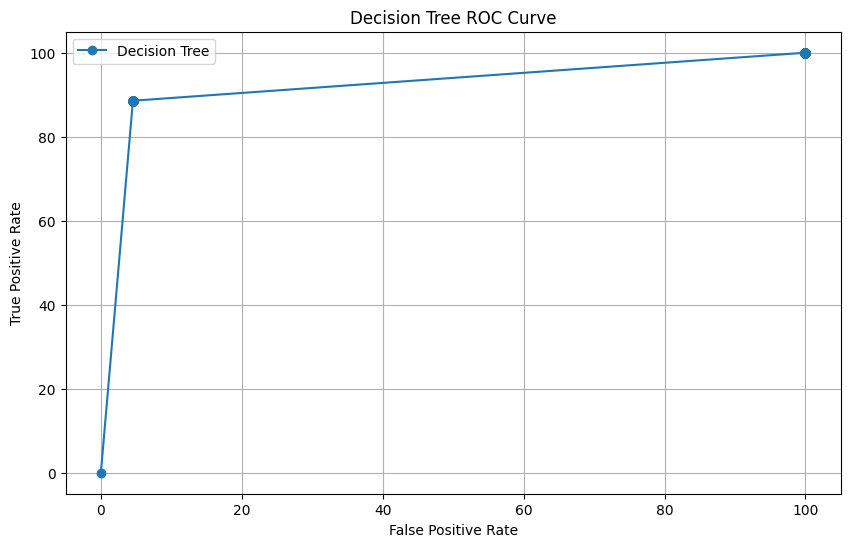

In [73]:
# Calculate ROC curve data for Decision Tree
dt_probabilities = bc_tree.predict_proba(X_test)
dt_tp_rates = []
dt_fp_rates = []

for threshold in range(0, 500, 1):
    threshold = threshold * 0.01
    dt_predictions = [0 if prob[0] >= threshold else 1 for prob in dt_probabilities]
    
    conf_matrix = get_confusion_matrix(X_test, y_test, predictions=dt_predictions)
    tp, fp = conf_matrix[0]
    fn, tn = conf_matrix[1]
    
    dt_tp_rates.append(tp)
    dt_fp_rates.append(fp)

# Normalize rates
dt_tp_rates = [100 * x / max(dt_tp_rates) for x in dt_tp_rates]
dt_fp_rates = [100 * x / max(dt_fp_rates) for x in dt_fp_rates]

# Plot Decision Tree ROC curve
plt.figure(figsize=(10, 6))
plt.plot(dt_fp_rates, dt_tp_rates, '-o', label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## Metrics

In [74]:
conf_matrix = get_confusion_matrix(X_test, y_test, bc_tree)
tp, fp = conf_matrix[0]
fn, tn = conf_matrix[1]

# Calculate metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nMetrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")



Metrics:
Precision: 0.9688
Recall: 0.8857
F1 Score: 0.9254


# K-Nearest Neighbours

In [75]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
probabilities = knn.predict_proba(X_test)

## Accuracy

In [76]:
knn_score = knn.score(X_test, y_test)
print(f"KNN Accuracy score: {knn_score:.4f}")


KNN Accuracy score: 0.8947


## Cross Validation

In [77]:
cv_scores = cross_val_score(knn, X, y, cv=10)
print(f"\nCross-validation results:")
print(f"Average score: {get_stats(cv_scores):.4f}")
print(f"Standard deviation: {get_stats(cv_scores, 2):.4f}")


Cross-validation results:
Average score: 0.9298
Standard deviation: 0.0309


## ROC Curve

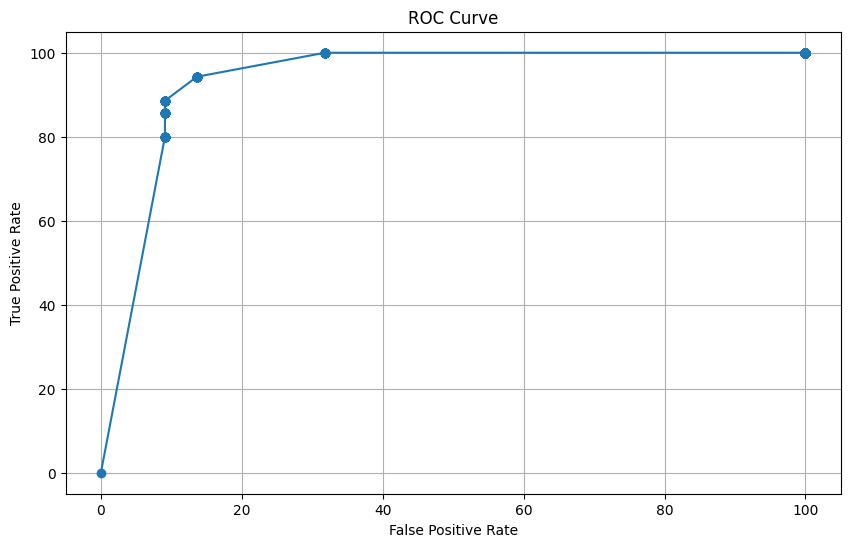

In [78]:

# Calculate ROC curve data
tp_rates = []
fp_rates = []
precisions = []
recalls = []

for threshold in range(0, 500, 1):
    threshold: float = threshold * 0.01
    predictions: list[int] = [0 if prob[0] >= threshold else 1 for prob in probabilities]
    
    conf_matrix = get_confusion_matrix(X_test, y_test, predictions=predictions)
    tp, fp = conf_matrix[0]
    fn, tn = conf_matrix[1]
    
    tp_rates.append(tp)
    fp_rates.append(fp)
    
    if tp + fp > 0:
        precisions.append(tp / (tp + fp))
    else:
        precisions.append(0)
        
    if tp + fn > 0:
        recalls.append(tp / (tp + fn))
    else:
        recalls.append(0)

# Normalize and plot ROC curve
tp_rates = [100 * x / max(tp_rates) for x in tp_rates]
fp_rates = [100 * x / max(fp_rates) for x in fp_rates]

plt.figure(figsize=(10, 6))
plt.plot(fp_rates, tp_rates, '-o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

## Metrics

In [79]:
avg_precision: float = get_stats(precisions)
avg_recall: float = get_stats(recalls)
avg_f1: float = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

print(f"\nFinal averaged metrics:")
print(f"Average Precision: {avg_precision:.4f} (±{get_stats(precisions, 2):.4f})")
print(f"Average Recall: {avg_recall:.4f} (±{get_stats(recalls, 2):.4f})")
print(f"Average F1 Score: {avg_f1:.4f}")


Final averaged metrics:
Average Precision: 0.6724 (±0.1243)
Average Recall: 0.9774 (±0.0676)
Average F1 Score: 0.7967


# Comparison

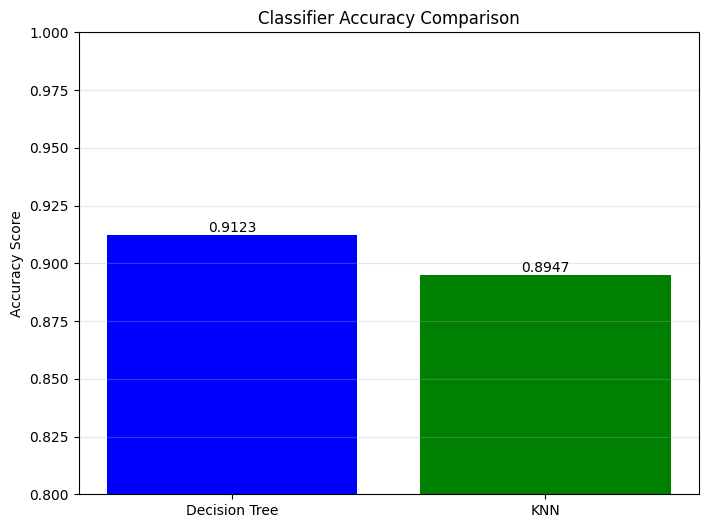

In [80]:
plt.figure(figsize=(8, 6))
plt.bar(['Decision Tree', 'KNN'], [score, knn_score], color=['blue', 'green'])
plt.title('Classifier Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.ylim(0.8, 1)  

plt.text('Decision Tree', score, f'{score:.4f}', ha='center', va='bottom')
plt.text('KNN', knn_score, f'{knn_score:.4f}', ha='center', va='bottom')

plt.grid(True, axis='y', alpha=0.3)
plt.show()

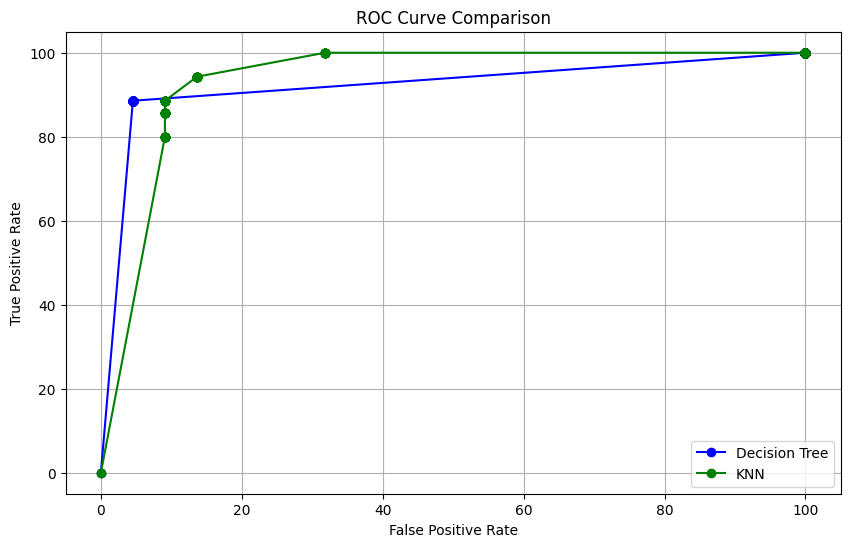

In [81]:
dt_probabilities = bc_tree.predict_proba(X_test)
knn_probabilities = knn.predict_proba(X_test)

dt_tp_rates = []
dt_fp_rates = []
knn_tp_rates = []
knn_fp_rates = []

for threshold in range(0, 500, 1):
	threshold = threshold * 0.01
	
	# Decision Tree predictions and rates
	dt_predictions = [0 if prob[0] >= threshold else 1 for prob in dt_probabilities]
	dt_conf_matrix = get_confusion_matrix(X_test, y_test, predictions=dt_predictions)
	dt_tp, dt_fp = dt_conf_matrix[0]
	dt_tp_rates.append(dt_tp)
	dt_fp_rates.append(dt_fp)
	
	# KNN predictions and rates
	knn_predictions = [0 if prob[0] >= threshold else 1 for prob in knn_probabilities]
	knn_conf_matrix = get_confusion_matrix(X_test, y_test, predictions=knn_predictions)
	knn_tp, knn_fp = knn_conf_matrix[0]
	knn_tp_rates.append(knn_tp)
	knn_fp_rates.append(knn_fp)

# Normalize rates
dt_tp_rates = [100 * x / max(dt_tp_rates) for x in dt_tp_rates]
dt_fp_rates = [100 * x / max(dt_fp_rates) for x in dt_fp_rates]
knn_tp_rates = [100 * x / max(knn_tp_rates) for x in knn_tp_rates]
knn_fp_rates = [100 * x / max(knn_fp_rates) for x in knn_fp_rates]

# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(dt_fp_rates, dt_tp_rates, '-o', label='Decision Tree', color='blue')
plt.plot(knn_fp_rates, knn_tp_rates, '-o', label='KNN', color='green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()